In [1]:
# Run Keras on CPU
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = " "         # -1 if CPU

In [2]:
# Importations
import sys
sys.path.append('..')

from config import *
import CPutils
import feature_extraction

Using TensorFlow backend.


In [3]:
# Plots style
def plt_style(titlesize=16,
              labelsize=14,
              legendsize=12,
              fontsize=14,
              figsize=(15,10)):
    # Font sizes
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['axes.labelsize'] = labelsize
    plt.rcParams['axes.titlesize'] = titlesize
    plt.rcParams['xtick.labelsize'] = labelsize
    plt.rcParams['ytick.labelsize'] = labelsize
    plt.rcParams['legend.fontsize'] = fontsize
    plt.rcParams['figure.titlesize'] = titlesize

    # Figure size
    plt.figure(1)
    plt.figure(figsize = figsize) 

    # axes
    ax = plt.subplot(111)                    
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left() 
    
    # Return axis
    return ax

# Pre-process data
- Excel files with land cover percentages and coordinates of the ignition points are pre-processed, generating a binary label based on the number of fires experienced during the study period.
- Images are associated with a certain ID that is recorded inside the excel file.
- Areas with less than 50% of land-cover (more than 50% of water) are discarded.
- Re-enumeration (1-N following the total number of pictures) and re-name: **CLASS_ID.tif** (CLASS $\in$ {0,1})
- Positive cases (fire) for training are copied into the **data/training/fire** folder and negative cases (no fire) are copied into te **data/training/no_fire** folder. Testing cases follow a similar convention, recording those images inside the **data/testing/fire** and **data/testing/no_fire** folders.
- A consolidated excel file containing the data from the processed images is generated
- We split the data into training and testing sets (75\%, 25\% respectively)

In [4]:
# Global variables
DATA_PATH = '../../data/AllTopologies'
CONSOLIDATED_PATH = '../../data/Consolidated_AllTopo'
TRAINING_PATH = '../../data/Consolidated_AllTopo/raining'
TESTING_PATH = '../../data/Consolidated_AllTopo/testing'

## Load excel files
- Create the binary label $fire \in$ {0,1} if the number of fires is at least 1 during the time period ($n\_inc \geq 1$).

In [5]:
# Container of excel files
topologiesXLS = {}
maxcolumns = []

# Load Excel files and create binary label (fire or no fire)
for i in range(10, 21):
    topologiesXLS[i] = pd.read_excel(os.path.join(DATA_PATH, 'Topology_' + str(i) + '.xlsx'))
    topologiesXLS[i].eval('fire = (n_inc > 0) * 1', inplace=True)
    
    if len(topologiesXLS[i].columns) > len(maxcolumns) and i != 12:
        maxcolumns = topologiesXLS[i].columns
        
    # Info
    print("Shape:", topologiesXLS[i].shape)
    display(topologiesXLS[i].head())

Shape: (9999, 19)


,id,Lat,Long,n_inc,n_inc_fut,lcV0,lcV1,lcV2,lcV3,lcV4,lcV5,lcV6,lcV7,lcV8,lcV9,lcV10,lcV11,lcVSUM,fire
0,1,-41.89776,-73.83894,0,0,0.000000,0.000000,0.717213,0.000000,0.181352,0.101434,0.0,0.000000,0.000000,0.000000,0.0,0.0,976,0
1,2,-33.45958,-70.72078,0,0,0.000000,0.111111,0.002291,0.000000,0.057274,0.600229,0.0,0.000000,0.171821,0.057274,0.0,0.0,873,0
2,3,-32.58694,-71.29355,0,0,0.000000,0.000000,0.006961,0.000000,0.156613,0.836427,0.0,0.000000,0.000000,0.000000,0.0,0.0,862,0
3,4,-38.77884,-73.41945,0,0,0.422460,0.000000,0.001070,0.000000,0.232086,0.049198,0.0,0.157219,0.011765,0.126203,0.0,0.0,935,0
4,5,-39.84982,-73.45822,0,0,0.863158,0.000000,0.016842,0.014737,0.066316,0.025263,0.0,0.012632,0.001053,0.000000,0.0,0.0,950,0


Shape: (9999, 19)


,id,Lat,Long,n_inc,n_inc_fut,lcV0,lcV1,lcV2,lcV3,lcV4,lcV5,lcV6,lcV7,lcV8,lcV9,lcV10,lcV11,lcVSUM,fire
0,1,-39.35690,-71.57505,0,0,0.0,0.000000,0.201699,0.001062,0.614650,0.182590,0.0,0.000000,0.000000,0.0,0.0,0.0,942,0
1,2,-33.99232,-71.86816,0,0,0.0,0.059497,0.021739,0.184211,0.120137,0.614416,0.0,0.000000,0.000000,0.0,0.0,0.0,874,0
2,3,-38.11339,-72.32531,0,1,0.0,0.227273,0.061688,0.095238,0.267316,0.348485,0.0,0.000000,0.000000,0.0,0.0,0.0,924,0
3,4,-35.43907,-71.73170,0,0,0.0,0.021158,0.410913,0.459911,0.000000,0.108018,0.0,0.000000,0.000000,0.0,0.0,0.0,898,0
4,5,-40.69044,-72.59952,0,0,0.0,0.004162,0.013528,0.000000,0.960458,0.007284,0.0,0.006243,0.008325,0.0,0.0,0.0,961,0


Shape: (9999, 19)


,id,Lat,Long,n_inc,n_inc_fut,lcV0,lcV1,lcV2,lcV3,lcV4,lcV5,lcV6,lcV7,lcV8,lcV9,lcV10,lcV11,lcVSUM,fire
0,1,-40.99496,-72.87966,0,0,0.0,0.005192,0.246106,0.037383,0.429907,0.005192,0.0,0.276220,0.000000,0.000000,0.0,0.0,963,0
1,2,-39.36590,-72.65715,0,0,0.0,0.018066,0.671626,0.285866,0.011690,0.012752,0.0,0.000000,0.000000,0.000000,0.0,0.0,941,0
2,3,-33.53971,-70.73616,0,1,0.0,0.273249,0.001148,0.000000,0.113662,0.233065,0.0,0.000000,0.211251,0.167623,0.0,0.0,871,0
3,4,-33.32050,-71.42686,0,0,0.0,0.330645,0.000000,0.000000,0.365207,0.302995,0.0,0.000000,0.001152,0.000000,0.0,0.0,868,0
4,5,-36.50819,-72.72538,0,1,0.0,0.057395,0.136865,0.102649,0.316777,0.364238,0.0,0.001104,0.020971,0.000000,0.0,0.0,906,0


Shape: (9999, 19)


,id,Lat,Long,n_inc,n_inc_fut,lcV0,lcV1,lcV2,lcV3,lcV4,lcV5,lcV6,lcV7,lcV8,lcV9,lcV10,lcV11,lcVSUM,fire
0,1,-33.40059,-70.74710,0,0,0.0,0.200913,0.000000,0.000000,0.067352,0.081050,0.000000,0.000000,0.552511,0.098174,0.0,0.0,876,0
1,2,-38.95954,-72.13808,0,0,0.0,0.013874,0.271078,0.030950,0.532551,0.127001,0.002134,0.020277,0.001067,0.001067,0.0,0.0,937,0
2,3,-33.55746,-70.74604,0,0,0.0,0.612644,0.004598,0.000000,0.020690,0.312644,0.000000,0.000000,0.034483,0.014943,0.0,0.0,870,0
3,4,-37.49289,-72.38971,0,1,0.0,0.444929,0.029444,0.027263,0.362050,0.126499,0.000000,0.000000,0.006543,0.003272,0.0,0.0,917,0
4,5,-37.60586,-72.54485,0,0,0.0,0.032644,0.057671,0.034820,0.466812,0.404788,0.000000,0.000000,0.003264,0.000000,0.0,0.0,919,0


Shape: (9999, 19)


,id,Lat,Long,n_inc,n_inc_fut,lcV0,lcV1,lcV2,lcV3,lcV4,lcV5,lcV6,lcV7,lcV8,lcV9,lcV10,lcV11,lcVSUM,fire
0,1,-39.79898,-73.26573,0,0,0.000000,0.000000,0.506835,0.092534,0.149317,0.050473,0.024185,0.176656,0.000000,0.000000,0.0,0.0,951,0
1,2,-39.63861,-72.31282,0,0,0.000000,0.002116,0.087831,0.007407,0.822222,0.069841,0.000000,0.002116,0.008466,0.000000,0.0,0.0,945,0
2,3,-33.56991,-70.54668,1,0,0.000000,0.073227,0.019451,0.000000,0.162471,0.572082,0.000000,0.000000,0.051487,0.121281,0.0,0.0,874,1
3,4,-34.48799,-72.01957,0,0,0.024887,0.041855,0.000000,0.038462,0.432127,0.395928,0.010181,0.033937,0.001131,0.021493,0.0,0.0,884,0
4,5,-38.72523,-72.52836,0,0,0.000000,0.030011,0.024652,0.000000,0.767417,0.177921,0.000000,0.000000,0.000000,0.000000,0.0,0.0,933,0


Shape: (9999, 19)


,id,Lat,Long,n_inc,n_inc_fut,lcV0,lcV1,lcV2,lcV3,lcV4,lcV5,lcV6,lcV7,lcV8,lcV9,lcV10,lcV11,lcVSUM,fire
0,1,-36.74066,-72.48983,0,0,0.0,0.007692,0.048352,0.031868,0.171429,0.732967,0.0,0.001099,0.005495,0.000000,0.0,0.001099,910,0
1,2,-36.65467,-73.03653,0,0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,909,0
2,3,-33.55224,-70.55795,0,0,0.0,0.240868,0.004566,0.000000,0.102740,0.465753,0.0,0.000000,0.152968,0.033105,0.0,0.000000,876,0
3,4,-34.37170,-71.19597,0,0,0.0,0.801812,0.001133,0.000000,0.037373,0.149490,0.0,0.000000,0.009060,0.001133,0.0,0.000000,883,0
4,5,-37.50642,-72.62781,3,1,0.0,0.048913,0.098913,0.389130,0.345652,0.117391,0.0,0.000000,0.000000,0.000000,0.0,0.000000,920,1


Shape: (9999, 19)


,id,Lat,Long,n_inc,n_inc_fut,lcV0,lcV1,lcV2,lcV3,lcV4,lcV5,lcV6,lcV7,lcV8,lcV9,lcV10,lcV11,lcVSUM,fire
0,1,-36.51192,-72.67948,0,0,0.0,0.000000,0.076923,0.698901,0.036264,0.187912,0.00000,0.000000,0.000000,0.000000,0.0,0.0,910,0
1,2,-33.02583,-71.26227,3,1,0.0,0.022989,0.000000,0.000000,0.221839,0.743678,0.00000,0.000000,0.008046,0.003448,0.0,0.0,870,1
2,3,-33.44040,-70.60158,0,0,0.0,0.057604,0.000000,0.000000,0.040323,0.690092,0.00000,0.000000,0.185484,0.026498,0.0,0.0,868,0
3,4,-33.49820,-70.55876,1,0,0.0,0.246843,0.063146,0.000000,0.063146,0.467279,0.00000,0.000000,0.102181,0.057405,0.0,0.0,871,1
4,5,-34.64068,-71.34338,0,0,0.0,0.653454,0.049830,0.006795,0.022650,0.169875,0.00453,0.005663,0.082673,0.004530,0.0,0.0,883,0


Shape: (9999, 19)


,id,Lat,Long,n_inc,n_inc_fut,lcV0,lcV1,lcV2,lcV3,lcV4,lcV5,lcV6,lcV7,lcV8,lcV9,lcV10,lcV11,lcVSUM,fire
0,1,-41.41692,-73.43654,0,0,0.0,0.007194,0.254882,0.000000,0.702980,0.034943,0.0,0.000000,0.000000,0.000000,0.0,0.0,973,0
1,2,-36.90198,-72.01330,0,0,0.0,0.540570,0.019737,0.008772,0.285088,0.144737,0.0,0.000000,0.001096,0.000000,0.0,0.0,912,0
2,3,-33.46106,-70.62922,0,0,0.0,0.020619,0.000000,0.000000,0.017182,0.109966,0.0,0.002291,0.673540,0.176403,0.0,0.0,873,0
3,4,-35.74363,-72.55315,1,0,0.0,0.005568,0.105791,0.521158,0.007795,0.359688,0.0,0.000000,0.000000,0.000000,0.0,0.0,898,1
4,5,-38.67911,-72.19518,0,0,0.0,0.233974,0.005342,0.000000,0.711538,0.049145,0.0,0.000000,0.000000,0.000000,0.0,0.0,936,0


Shape: (9999, 19)


,id,Lat,Long,n_inc,n_inc_fut,lcV0,lcV1,lcV2,lcV3,lcV4,lcV5,lcV6,lcV7,lcV8,lcV9,lcV10,lcV11,lcVSUM,fire
0,1,-35.12498,-71.31259,0,0,0.000000,0.775648,0.027057,0.001127,0.010147,0.167982,0.0,0.002255,0.015784,0.000000,0.0,0.0,887,0
1,2,-39.86412,-73.20017,0,1,0.000000,0.000000,0.015789,0.000000,0.807368,0.176842,0.0,0.000000,0.000000,0.000000,0.0,0.0,950,0
2,3,-33.49667,-70.81100,1,2,0.000000,0.392202,0.010321,0.000000,0.099771,0.438073,0.0,0.000000,0.050459,0.009174,0.0,0.0,872,1
3,4,-37.09857,-73.17244,0,0,0.934066,0.002198,0.013187,0.005495,0.003297,0.018681,0.0,0.023077,0.000000,0.000000,0.0,0.0,910,0
4,5,-36.85128,-73.04161,0,0,0.000000,0.008791,0.316484,0.581319,0.039560,0.049451,0.0,0.000000,0.004396,0.000000,0.0,0.0,910,0


Shape: (9999, 19)


,id,Lat,Long,n_inc,n_inc_fut,lcV0,lcV1,lcV2,lcV3,lcV4,lcV5,lcV6,lcV7,lcV8,lcV9,lcV10,lcV11,lcVSUM,fire
0,1,-37.09884,-72.59673,0,0,0.0,0.102957,0.012048,0.020811,0.679080,0.185104,0.00000,0.000000,0.000000,0.000000,0.0,0.0,913,0
1,2,-34.60104,-71.64243,0,1,0.0,0.003390,0.005650,0.151412,0.205650,0.622599,0.00565,0.002260,0.000000,0.003390,0.0,0.0,885,0
2,3,-33.41046,-70.58770,0,0,0.0,0.268124,0.049482,0.000000,0.055236,0.535098,0.00000,0.004603,0.028769,0.058688,0.0,0.0,869,0
3,4,-33.04967,-71.42685,1,2,0.0,0.033487,0.000000,0.005774,0.230947,0.227483,0.00000,0.000000,0.488453,0.013857,0.0,0.0,866,1
4,5,-29.92657,-71.31595,0,0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,840,0


Shape: (9999, 19)


,id,Lat,Long,n_inc,n_inc_fut,lcV0,lcV1,lcV2,lcV3,lcV4,lcV5,lcV6,lcV7,lcV8,lcV9,lcV10,lcV11,lcVSUM,fire
0,1,-37.64305,-73.64683,1,1,0.0,0.000000,0.276688,0.663399,0.053377,0.006536,0.0,0.000000,0.000000,0.000000,0.0,0.0,918,1
1,2,-39.08288,-73.16450,0,0,0.0,0.078075,0.032086,0.002139,0.835294,0.036364,0.0,0.016043,0.000000,0.000000,0.0,0.0,935,0
2,3,-33.66440,-70.92421,0,0,0.0,0.144994,0.002301,0.000000,0.060990,0.234753,0.0,0.000000,0.553510,0.003452,0.0,0.0,869,0
3,4,-37.28105,-71.95377,4,4,0.0,0.003282,0.019694,0.327133,0.249453,0.399344,0.0,0.000000,0.001094,0.000000,0.0,0.0,914,1
4,5,-34.34978,-70.91764,0,0,0.0,0.867882,0.076310,0.000000,0.001139,0.052392,0.0,0.000000,0.002278,0.000000,0.0,0.0,878,0


In [6]:
# Total columns
maxcolumns

Index(['id', 'Lat', 'Long', 'n_inc', 'n_inc_fut', 'lcV0', 'lcV1', 'lcV2',
       'lcV3', 'lcV4', 'lcV5', 'lcV6', 'lcV7', 'lcV8', 'lcV9', 'lcV10',
       'lcV11', 'lcVSUM', 'fire'],
      dtype='object')

In [7]:
# Consolidate the number of columns and their order
for k in np.sort([k for k in topologiesXLS.keys()]):
    for c in maxcolumns:
        if c not in topologiesXLS[k].columns:
            topologiesXLS[k][c] = np.zeros(topologiesXLS[k].shape[0])
    topologiesXLS[k] = topologiesXLS[k][maxcolumns]
    print("Database", k)
    print("\tOriginal Shape (pre lcV0 filter 10%):", topologiesXLS[k].shape)
    topologiesXLS[k] = topologiesXLS[k][topologiesXLS[k].lcV0 < .1]
    print("\tNew Shape (lcV0 filter 10%):", topologiesXLS[k].shape)

Database 10
	Original Shape (pre lcV0 filter 10%): (9999, 19)
	New Shape (lcV0 filter 10%): (9117, 19)
Database 11
	Original Shape (pre lcV0 filter 10%): (9999, 19)
	New Shape (lcV0 filter 10%): (9092, 19)
Database 12
	Original Shape (pre lcV0 filter 10%): (9999, 19)
	New Shape (lcV0 filter 10%): (9130, 19)
Database 13
	Original Shape (pre lcV0 filter 10%): (9999, 19)
	New Shape (lcV0 filter 10%): (9114, 19)
Database 14
	Original Shape (pre lcV0 filter 10%): (9999, 19)
	New Shape (lcV0 filter 10%): (9130, 19)
Database 15
	Original Shape (pre lcV0 filter 10%): (9999, 19)
	New Shape (lcV0 filter 10%): (9152, 19)
Database 16
	Original Shape (pre lcV0 filter 10%): (9999, 19)
	New Shape (lcV0 filter 10%): (9106, 19)
Database 17
	Original Shape (pre lcV0 filter 10%): (9999, 19)
	New Shape (lcV0 filter 10%): (9186, 19)
Database 18
	Original Shape (pre lcV0 filter 10%): (9999, 19)
	New Shape (lcV0 filter 10%): (9169, 19)
Database 19
	Original Shape (pre lcV0 filter 10%): (9999, 19)
	New Shape 

# Filter non-fires
- Terrains dominated by water are discarded in order to decrease the bias of non-positive cases when comparing structures.
- $lcV7$ = water bodies and $lcV10$ = snow and ice are used to filter the dataset. If the summation of these variables is larger than 50% (.5) then, we do not include the sample in our dataset. 

In [8]:
# Filtering loop
for k in np.sort([k for k in topologiesXLS.keys()]):
    print("Dataset", k)
    if 'lcV10' in topologiesXLS[k].columns:
        print("\tNumber of discarded cases due to water levels (lcV10):", 
          topologiesXLS[k][(topologiesXLS[k].lcV7 + topologiesXLS[k].lcV10) >= .5].shape)
        
        topologiesXLS[k] = topologiesXLS[k][(topologiesXLS[k].lcV7 + topologiesXLS[k].lcV10) < .5]
        print("\tNew Dim:", topologiesXLS[k].shape)
        
    else:
        print("\tNumber of discarded cases due to water levels:", 
          topologiesXLS[k][topologiesXLS[k].lcV7 >= .5].shape)
        topologiesXLS[k] = topologiesXLS[k][(topologiesXLS[k].lcV7) < .5]
        print("\tNew Dim", topologiesXLS[k].shape)

Dataset 10
	Number of discarded cases due to water levels (lcV10): (135, 19)
	New Dim: (8982, 19)
Dataset 11
	Number of discarded cases due to water levels (lcV10): (149, 19)
	New Dim: (8943, 19)
Dataset 12
	Number of discarded cases due to water levels (lcV10): (140, 19)
	New Dim: (8990, 19)
Dataset 13
	Number of discarded cases due to water levels (lcV10): (144, 19)
	New Dim: (8970, 19)
Dataset 14
	Number of discarded cases due to water levels (lcV10): (144, 19)
	New Dim: (8986, 19)
Dataset 15
	Number of discarded cases due to water levels (lcV10): (131, 19)
	New Dim: (9021, 19)
Dataset 16
	Number of discarded cases due to water levels (lcV10): (155, 19)
	New Dim: (8951, 19)
Dataset 17
	Number of discarded cases due to water levels (lcV10): (131, 19)
	New Dim: (9055, 19)
Dataset 18
	Number of discarded cases due to water levels (lcV10): (139, 19)
	New Dim: (9030, 19)
Dataset 19
	Number of discarded cases due to water levels (lcV10): (139, 19)
	New Dim: (8980, 19)
Dataset 20
	Number o

# Filter by images
- Check the images available from the different folders and filter the excel files based on their availability.
- Read images names from raw datasets, get the ids available and drop the non available ones from the excel files.

In [9]:
# ID containers
topologiesIDs = {}

# Excel loops
for k in np.sort([k for k in topologiesXLS.keys()]):
    print("Reading ids from dataset", k, "...")
    topologiesIDs[k] = []

    # Get pictures
    p = os.path.join(DATA_PATH, 'Topology_' +str(k))
    imagePaths = sorted(list(paths.list_images(p)))
    
    # Image per excel loops
    for imagePath in imagePaths:
        filename = imagePath.split(os.path.sep)[-1]
        rs = re.search( r'ID(\d+)\.tif', filename)
        ID = rs.group(1)
        topologiesIDs[k].append(ID)
        
    # Total number of images
    print("\tTotal # images:", len(topologiesIDs[k]))

Reading ids from dataset 10 ...
	Total # images: 9729
Reading ids from dataset 11 ...
	Total # images: 9999
Reading ids from dataset 12 ...
	Total # images: 9999
Reading ids from dataset 13 ...
	Total # images: 9999
Reading ids from dataset 14 ...
	Total # images: 9999
Reading ids from dataset 15 ...
	Total # images: 9999
Reading ids from dataset 16 ...
	Total # images: 9999
Reading ids from dataset 17 ...
	Total # images: 9999
Reading ids from dataset 18 ...
	Total # images: 9999
Reading ids from dataset 19 ...
	Total # images: 9999
Reading ids from dataset 20 ...
	Total # images: 9999


In [10]:
# Filter excel files
for k in np.sort([k for k in topologiesXLS.keys()]):
    print("Filtering dataset", k, "by images ids...")
    print("\tInitial shape:", topologiesXLS[k].shape)
    topologiesXLS[k] = topologiesXLS[k][topologiesXLS[k]['id'].isin(topologiesIDs[k])]
    print("\tFinal shape:", topologiesXLS[k].shape)

Filtering dataset 10 by images ids...
	Initial shape: (8982, 19)
	Final shape: (8742, 19)
Filtering dataset 11 by images ids...
	Initial shape: (8943, 19)
	Final shape: (8943, 19)
Filtering dataset 12 by images ids...
	Initial shape: (8990, 19)
	Final shape: (8990, 19)
Filtering dataset 13 by images ids...
	Initial shape: (8970, 19)
	Final shape: (8970, 19)
Filtering dataset 14 by images ids...
	Initial shape: (8986, 19)
	Final shape: (8986, 19)
Filtering dataset 15 by images ids...
	Initial shape: (9021, 19)
	Final shape: (9021, 19)
Filtering dataset 16 by images ids...
	Initial shape: (8951, 19)
	Final shape: (8951, 19)
Filtering dataset 17 by images ids...
	Initial shape: (9055, 19)
	Final shape: (9055, 19)
Filtering dataset 18 by images ids...
	Initial shape: (9030, 19)
	Final shape: (9030, 19)
Filtering dataset 19 by images ids...
	Initial shape: (8980, 19)
	Final shape: (8980, 19)
Filtering dataset 20 by images ids...
	Initial shape: (8933, 19)
	Final shape: (8933, 19)


# Consolidate Excel
- Create a unique file containing all data information.
- Transform ids of independent datasets into correlative ones.
- New file names.

In [12]:
# Get total number of observations per set
prevtotalIds = 0
totalIds = 0
currentIds = 0

# DFs loop
for k in np.sort([k for k in topologiesXLS.keys()]):
    # Current ids and total number of ids so far
    currentIds = topologiesXLS[k].shape[0]
    totalIds += currentIds
    
    # new_id field (correlative)
    if k == 0:
        topologiesXLS[k]['new_id'] = np.arange(0, totalIds).astype(np.int)
    else:
        topologiesXLS[k]['new_id'] = np.arange(prevtotalIds, totalIds).astype(np.int)
        
    topologiesXLS[k]['topo_set'] = np.full(topologiesXLS[k].shape[0], k)
        
    # Uptade aux var
    prevtotalIds = totalIds

In [13]:
# Concatenate (by rows) excel
consolidatedTop = pd.concat([topologiesXLS[k] for k in np.sort([k for k in topologiesXLS.keys()])], axis=0)
consolidatedTop.head()

,id,Lat,Long,n_inc,n_inc_fut,lcV0,lcV1,lcV2,lcV3,lcV4,...,lcV6,lcV7,lcV8,lcV9,lcV10,lcV11,lcVSUM,fire,new_id,topo_set
0,1,-41.89776,-73.83894,0,0,0.0,0.000000,0.717213,0.000000,0.181352,...,0.0,0.0,0.000000,0.000000,0.0,0.0,976,0,0,10
1,2,-33.45958,-70.72078,0,0,0.0,0.111111,0.002291,0.000000,0.057274,...,0.0,0.0,0.171821,0.057274,0.0,0.0,873,0,1,10
2,3,-32.58694,-71.29355,0,0,0.0,0.000000,0.006961,0.000000,0.156613,...,0.0,0.0,0.000000,0.000000,0.0,0.0,862,0,2,10
5,6,-33.56879,-70.61928,0,0,0.0,0.431034,0.000000,0.000000,0.154023,...,0.0,0.0,0.049425,0.001149,0.0,0.0,870,0,3,10
6,7,-32.73892,-71.18942,0,0,0.0,0.650867,0.030058,0.017341,0.046243,...,0.0,0.0,0.013873,0.000000,0.0,0.0,865,0,4,10


In [14]:
# Old names (CLASS_ID)
consolidatedTop['old_file_name'] = 'ID' + consolidatedTop['id'].astype(str) + '.tif'
consolidatedTop.head()

,id,Lat,Long,n_inc,n_inc_fut,lcV0,lcV1,lcV2,lcV3,lcV4,...,lcV7,lcV8,lcV9,lcV10,lcV11,lcVSUM,fire,new_id,topo_set,old_file_name
0,1,-41.89776,-73.83894,0,0,0.0,0.000000,0.717213,0.000000,0.181352,...,0.0,0.000000,0.000000,0.0,0.0,976,0,0,10,ID1.tif
1,2,-33.45958,-70.72078,0,0,0.0,0.111111,0.002291,0.000000,0.057274,...,0.0,0.171821,0.057274,0.0,0.0,873,0,1,10,ID2.tif
2,3,-32.58694,-71.29355,0,0,0.0,0.000000,0.006961,0.000000,0.156613,...,0.0,0.000000,0.000000,0.0,0.0,862,0,2,10,ID3.tif
5,6,-33.56879,-70.61928,0,0,0.0,0.431034,0.000000,0.000000,0.154023,...,0.0,0.049425,0.001149,0.0,0.0,870,0,3,10,ID6.tif
6,7,-32.73892,-71.18942,0,0,0.0,0.650867,0.030058,0.017341,0.046243,...,0.0,0.013873,0.000000,0.0,0.0,865,0,4,10,ID7.tif


In [15]:
# New names (CLASS_ID)
consolidatedTop['new_file_name_fire'] = consolidatedTop['fire'].astype(str)  + '_' +  consolidatedTop["new_id"].astype(str)
consolidatedTop

,id,Lat,Long,n_inc,n_inc_fut,lcV0,lcV1,lcV2,lcV3,lcV4,...,lcV8,lcV9,lcV10,lcV11,lcVSUM,fire,new_id,topo_set,old_file_name,new_file_name_fire
0,1,-41.89776,-73.83894,0,0,0.0,0.000000,0.717213,0.000000,0.181352,...,0.000000,0.000000,0.0,0.000000,976,0,0,10,ID1.tif,0_0
1,2,-33.45958,-70.72078,0,0,0.0,0.111111,0.002291,0.000000,0.057274,...,0.171821,0.057274,0.0,0.000000,873,0,1,10,ID2.tif,0_1
2,3,-32.58694,-71.29355,0,0,0.0,0.000000,0.006961,0.000000,0.156613,...,0.000000,0.000000,0.0,0.000000,862,0,2,10,ID3.tif,0_2
5,6,-33.56879,-70.61928,0,0,0.0,0.431034,0.000000,0.000000,0.154023,...,0.049425,0.001149,0.0,0.000000,870,0,3,10,ID6.tif,0_3
6,7,-32.73892,-71.18942,0,0,0.0,0.650867,0.030058,0.017341,0.046243,...,0.013873,0.000000,0.0,0.000000,865,0,4,10,ID7.tif,0_4
7,8,-38.04992,-72.38633,2,2,0.0,0.496224,0.046386,0.116505,0.166127,...,0.000000,0.000000,0.0,0.000000,927,1,5,10,ID8.tif,1_5
8,9,-39.62436,-72.31734,0,0,0.0,0.000000,0.044492,0.000000,0.883475,...,0.001059,0.001059,0.0,0.000000,944,0,6,10,ID9.tif,0_6
9,10,-37.14607,-71.98532,0,0,0.0,0.896930,0.044956,0.002193,0.008772,...,0.000000,0.000000,0.0,0.000000,912,0,7,10,ID10.tif,0_7
10,11,-33.00779,-71.47922,2,1,0.0,0.002299,0.020690,0.002299,0.226437,...,0.000000,0.000000,0.0,0.000000,870,1,8,10,ID11.tif,1_8
11,12,-33.04449,-71.55196,1,0,0.0,0.034602,0.041522,0.035755,0.155709,...,0.161476,0.004614,0.0,0.000000,867,1,9,10,ID12.tif,1_9


In [17]:
# Fire any class
consolidatedTop.eval('fire_future = 1 * (n_inc_fut > 0)', inplace=True)
consolidatedTop.eval('fire_past_or_future = 1 * ((n_inc > 0) | (n_inc_fut > 0))', inplace=True)
consolidatedTop

,id,Lat,Long,n_inc,n_inc_fut,lcV0,lcV1,lcV2,lcV3,lcV4,...,lcV10,lcV11,lcVSUM,fire,new_id,topo_set,old_file_name,new_file_name_fire,fire_past_or_future,fire_future
0,1,-41.89776,-73.83894,0,0,0.0,0.000000,0.717213,0.000000,0.181352,...,0.0,0.000000,976,0,0,10,ID1.tif,0_0,0,0
1,2,-33.45958,-70.72078,0,0,0.0,0.111111,0.002291,0.000000,0.057274,...,0.0,0.000000,873,0,1,10,ID2.tif,0_1,0,0
2,3,-32.58694,-71.29355,0,0,0.0,0.000000,0.006961,0.000000,0.156613,...,0.0,0.000000,862,0,2,10,ID3.tif,0_2,0,0
5,6,-33.56879,-70.61928,0,0,0.0,0.431034,0.000000,0.000000,0.154023,...,0.0,0.000000,870,0,3,10,ID6.tif,0_3,0,0
6,7,-32.73892,-71.18942,0,0,0.0,0.650867,0.030058,0.017341,0.046243,...,0.0,0.000000,865,0,4,10,ID7.tif,0_4,0,0
7,8,-38.04992,-72.38633,2,2,0.0,0.496224,0.046386,0.116505,0.166127,...,0.0,0.000000,927,1,5,10,ID8.tif,1_5,1,1
8,9,-39.62436,-72.31734,0,0,0.0,0.000000,0.044492,0.000000,0.883475,...,0.0,0.000000,944,0,6,10,ID9.tif,0_6,0,0
9,10,-37.14607,-71.98532,0,0,0.0,0.896930,0.044956,0.002193,0.008772,...,0.0,0.000000,912,0,7,10,ID10.tif,0_7,0,0
10,11,-33.00779,-71.47922,2,1,0.0,0.002299,0.020690,0.002299,0.226437,...,0.0,0.000000,870,1,8,10,ID11.tif,1_8,1,1
11,12,-33.04449,-71.55196,1,0,0.0,0.034602,0.041522,0.035755,0.155709,...,0.0,0.000000,867,1,9,10,ID12.tif,1_9,1,0


In [18]:
# Sanity check
print("Total number of fires:\t\t", consolidatedTop[consolidatedTop.fire == 1].shape[0])
print("Total number of no fires:\t", consolidatedTop[consolidatedTop.fire == 0].shape[0])
print("Total number of any fires:\t", consolidatedTop[consolidatedTop.fire_past_or_future == 1].shape[0])
print("Total number of no any fires:\t", consolidatedTop[consolidatedTop.fire_past_or_future == 0].shape[0])
print("Total samples:\t\t\t", consolidatedTop.shape[0])

Total number of fires:		 20201
Total number of no fires:	 78400
Total number of any fires:	 29213
Total number of no any fires:	 69388
Total samples:			 98601


In [19]:
# Stats
consolidatedTop.n_inc.describe()

count    98601.000000
mean         0.640490
std          3.075665
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        174.000000
Name: n_inc, dtype: float64

In [20]:
consolidatedTop.n_inc_fut.describe()

count    98601.000000
mean         0.521415
std          2.042189
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         62.000000
Name: n_inc_fut, dtype: float64

In [21]:
# Total number of fires in different sections
from collections import Counter
print(Counter(consolidatedTop.n_inc))

Counter({0: 78400, 1: 10581, 2: 3722, 3: 1786, 4: 1049, 5: 708, 6: 466, 7: 332, 8: 259, 9: 203, 10: 174, 11: 122, 12: 101, 13: 77, 14: 73, 15: 64, 16: 59, 17: 36, 18: 33, 19: 28, 22: 28, 21: 20, 24: 19, 20: 17, 23: 15, 26: 13, 27: 12, 29: 11, 28: 10, 37: 9, 25: 8, 31: 8, 30: 7, 33: 7, 35: 7, 50: 7, 34: 6, 52: 6, 61: 6, 32: 5, 38: 5, 39: 5, 41: 5, 53: 5, 36: 4, 49: 4, 55: 4, 65: 4, 40: 3, 42: 3, 43: 3, 48: 3, 51: 3, 54: 3, 71: 3, 46: 2, 47: 2, 57: 2, 58: 2, 60: 2, 62: 2, 63: 2, 64: 2, 66: 2, 110: 2, 115: 2, 44: 1, 45: 1, 56: 1, 67: 1, 69: 1, 70: 1, 72: 1, 74: 1, 76: 1, 78: 1, 81: 1, 83: 1, 86: 1, 87: 1, 91: 1, 92: 1, 96: 1, 97: 1, 98: 1, 102: 1, 103: 1, 105: 1, 107: 1, 116: 1, 122: 1, 123: 1, 127: 1, 174: 1})


In [22]:
# Total number of fires in different sections
from collections import Counter
print(Counter(consolidatedTop.n_inc_fut))

Counter({0: 79106, 1: 10822, 2: 3552, 3: 1687, 4: 907, 5: 625, 6: 431, 7: 276, 8: 205, 9: 188, 10: 132, 11: 108, 12: 81, 13: 61, 14: 59, 16: 47, 15: 42, 18: 31, 17: 26, 19: 26, 20: 18, 22: 17, 21: 15, 24: 13, 25: 11, 26: 10, 27: 9, 34: 8, 28: 7, 30: 7, 23: 6, 39: 5, 42: 5, 44: 5, 29: 4, 32: 4, 37: 4, 41: 4, 45: 4, 46: 4, 31: 3, 36: 3, 33: 2, 43: 2, 48: 2, 51: 2, 53: 2, 59: 2, 60: 2, 62: 2, 35: 1, 38: 1, 40: 1, 50: 1, 52: 1, 55: 1, 58: 1})


# Generate consolidated image set
- Select and copy all those pictures present in the consolidated excel file.
- Each image file is denoted as CLASS_ID.tif, with CLASS_ID = 1 if it represents a structure where a fire has occurred.

In [23]:
consolidatedTop.columns

Index(['id', 'Lat', 'Long', 'n_inc', 'n_inc_fut', 'lcV0', 'lcV1', 'lcV2',
       'lcV3', 'lcV4', 'lcV5', 'lcV6', 'lcV7', 'lcV8', 'lcV9', 'lcV10',
       'lcV11', 'lcVSUM', 'fire', 'new_id', 'topo_set', 'old_file_name',
       'new_file_name_fire', 'fire_past_or_future', 'fire_future'],
      dtype='object')

In [40]:
# Extra importation (for copying)
import shutil
CONSOLIDATED_PATH = '../../data/Consolidated_allTopologies'

# Save consolidated dataset into new path
if not os.path.exists(CONSOLIDATED_PATH):
    os.makedirs(CONSOLIDATED_PATH)
    
# Loop over all images of each independent set, copying the matches into the consolidated folder
# with their new names
# Excel loops
for k in np.sort([k for k in topologiesXLS.keys()]):
    print("Processing images from dataset", k, "...")

    # Get pictures
    p = os.path.join(DATA_PATH, 'Topology_' + str(k))
    imagePaths = sorted(list(paths.list_images(p)))

    # Image per excel loops
    for imagePath in imagePaths:
        filename = imagePath.split(os.path.sep)[-1]
        rs = re.search( r'ID(\d+)\.tif', filename)
        ID = rs.group(1)
        if int(ID) in topologiesXLS[k].id.values:
            outname = str(topologiesXLS[k][topologiesXLS[k].id == int(ID)]['fire'].values[0]) + '_' + \
                      str(topologiesXLS[k][topologiesXLS[k].id == int(ID)]['new_id'].values[0]) + ".tif"
            newPath = os.path.join(CONSOLIDATED_PATH, outname)
            shutil.copy2(imagePath, newPath)

Processing images from dataset 10 ...
Processing images from dataset 11 ...
Processing images from dataset 12 ...
Processing images from dataset 13 ...
Processing images from dataset 14 ...
Processing images from dataset 15 ...
Processing images from dataset 16 ...
Processing images from dataset 17 ...
Processing images from dataset 18 ...
Processing images from dataset 19 ...
Processing images from dataset 20 ...


In [ ]:
# New fire vars set
import shutil
CONSOLIDATED_PATH2 = '../../data/Consolidated_allTopologies'
old_new_names = consolidatedTop[['new_file_name_fire', 'new_file_name_anyfire']]
counter = 1

# Save consolidated dataset into new path
if not os.path.exists(CONSOLIDATED_PATH2):
    os.makedirs(CONSOLIDATED_PATH2)
    
# Loop over all images of each independent set, copying the matches into the consolidated folder
# with their new names
# Excel loops
imagePaths = sorted(list(paths.list_images(CONSOLIDATED_PATH)))

# Image per excel loops
for imagePath in imagePaths:
    if counter % 1000 == 0 or counter == 1:
        print("Number of pictures processed", counter)
    filename = imagePath.split(os.path.sep)[-1][:-4]
    row = old_new_names[old_new_names.new_file_name_fire == filename]
    #print(filename)
    #print(row.values.flatten()[1])
    newPath = os.path.join(CONSOLIDATED_PATH2, row.values.flatten()[1] + '.tif')
    shutil.copy2(imagePath, newPath)
    counter += 1

In [41]:
# Check final calculations
consolidatedTop.eval('future_fire = (n_inc_fut > 0) * 1', inplace=True)
consolidatedTop.eval('same_cat_past_future = (fire == future_fire) * 1', inplace=True)
consolidatedTop.eval('fire_past_and_future = ((fire == future_fire) & (fire == 1)) *  1', inplace=True)
consolidatedTop.eval('no_fire_past_and_fire_future = ((future_fire == 1) & (fire == 0)) *  1', inplace=True)
consolidatedTop.eval('fire_past_or_future = ((future_fire == 1) | (fire == 1)) *  1', inplace=True)

In [42]:
# Sanity check
print("Total number of fires:\t\t", consolidatedTop[consolidatedTop.fire == 1].shape[0])
print("Total number of no fires:\t", consolidatedTop[consolidatedTop.fire == 0].shape[0])
print("Total number of any fires:\t", consolidatedTop[consolidatedTop.fire_past_or_future == 1].shape[0])
print("Total number of no any fires:\t", consolidatedTop[consolidatedTop.fire_past_or_future == 0].shape[0])
print("Total samples:\t\t\t", consolidatedTop.shape[0])

Total number of fires:		 20201
Total number of no fires:	 78400
Total number of any fires:	 29213
Total number of no any fires:	 69388
Total samples:			 98601


In [43]:
# Save consolidated excel file 
consolidatedTop.to_excel(os.path.join(CONSOLIDATED_PATH, 'Topology_100k.xlsx'))

# Transform images into PNG/JPEG
- The provided tif files do not have channels (1D matrix). Thus, we generate an auxiliary dataset of pictures in png format in case we need it.

In [ ]:
tifTest = '../data/Consolidated_allData_fire/fire/1_8.tif'
I = plt.imread(tifTest)
plt.imshow(I, cmap='gray')

In [44]:
# Generate png files
NEW_CONSOLIDATED_PATH = '../../data/Consolidated_allTopologiesPNG'
outFormat = 'png'
ids_to_eliminate = []

# Create output folder
if not os.path.exists(NEW_CONSOLIDATED_PATH):
    os.makedirs(NEW_CONSOLIDATED_PATH)

# Format transformation loop
p = os.path.join(CONSOLIDATED_PATH, 'dataset')
imagePaths = sorted(list(paths.list_images(p)))
for imagePath in imagePaths:
    try:
        I = plt.imread(imagePath)
        filename = imagePath.split(os.path.sep)[-1]
        plt.imsave(os.path.join(NEW_CONSOLIDATED_PATH, filename[:-3] + outFormat), I, cmap='gray')
    except:
        ids_to_eliminate.append(filename)

In [45]:
ids_to_eliminate

['0_17969.tif',
 '0_18889.tif',
 '0_63209.tif',
 '0_63508.tif',
 '0_65859.tif',
 '0_66029.tif',
 '0_66619.tif',
 '0_66929.tif',
 '0_67476.tif',
 '0_67538.tif',
 '0_68119.tif',
 '0_68149.tif',
 '0_68179.tif',
 '0_68399.tif',
 '0_68929.tif',
 '0_69689.tif',
 '0_69769.tif',
 '0_69849.tif',
 '0_70209.tif',
 '0_70279.tif',
 '0_72509.tif',
 '0_72638.tif',
 '0_734.tif',
 '0_73478.tif',
 '0_735.tif',
 '0_74599.tif',
 '0_74629.tif',
 '0_74639.tif',
 '0_74739.tif',
 '0_74759.tif',
 '0_75099.tif',
 '0_77939.tif',
 '0_78269.tif',
 '0_78299.tif',
 '0_78599.tif',
 '0_78749.tif',
 '0_789.tif',
 '0_79667.tif',
 '0_797.tif',
 '0_79708.tif',
 '0_79869.tif',
 '0_813.tif',
 '0_81338.tif',
 '0_81428.tif',
 '0_81479.tif',
 '0_81549.tif',
 '0_81628.tif',
 '0_81639.tif',
 '0_81709.tif',
 '0_81849.tif',
 '0_81919.tif',
 '0_82349.tif',
 '0_82559.tif',
 '0_826.tif',
 '0_82648.tif',
 '0_83308.tif',
 '0_83679.tif',
 '0_83909.tif',
 '0_84249.tif',
 '0_84269.tif',
 '0_84379.tif',
 '0_84389.tif',
 '0_844.tif',
 '0_84

In [46]:
mask = [ids[:-4] for ids in ids_to_eliminate]
print(len(mask))
print(consolidatedTop.shape)
consolidatedTop[~consolidatedTop.new_file_name_fire.isin(mask)]
print(consolidatedTop.shape)

77
(98601, 29)
(98601, 29)


# Visualizations
- Transform .tif files into normal image format
- Montages for fire and non-fire sets (sanity check)

(31, 39)


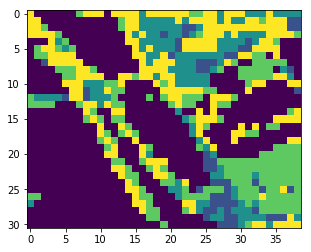

In [48]:
# Original .tif files contain a unique channel, therefore we need to pass -1 to read them
_ = cv2.imread('data/Consolidated_allTopologies/fire/1_5.tif', -1)
print(_.shape)
plt.imshow(_, cmap='viridis')
#plt.imsave('test.jpeg', _, dpi=200, cmap='gray')

In [ ]:
# Check jpeg quality (not the best)
_ = cv2.imread('data/Consolidated_allTopologiesPNG/0_2.jpeg')
print(_.shape)
plt.imshow(_, cmap='viridis')

(32, 37)


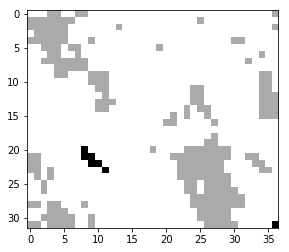

In [50]:
# Check original tif
_ = cv2.imread('data/Consolidated_allTopologies/dataset/0_2.tif', -1)
print(_.shape)
plt.imshow(_, cmap='gray')

(32, 37, 3)


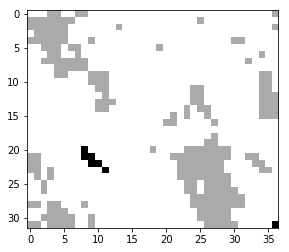

In [53]:
# Check png quality (identical to .tif)
I = cv2.imread('data/Consolidated_allTopologiesPNG/dataset/0_2.png')
print(I.shape)
plt.imshow(I, cmap='gray')

In [54]:
# Build montage
montage = CPutils.montage_data(sample=900, 
                               dataset=NEW_CONSOLIDATED_PATH, 
                               save=False, 
                               text='Sample Training Set', 
                               textCoord=(0,0), 
                               textColor=0, 
                               outFileName=None,
                               imgShape=(128,128),
                               montageShape=(30,30),
                               fontScale=2,
                               seed=42,
                               show=False)

<Figure size 432x288 with 0 Axes>

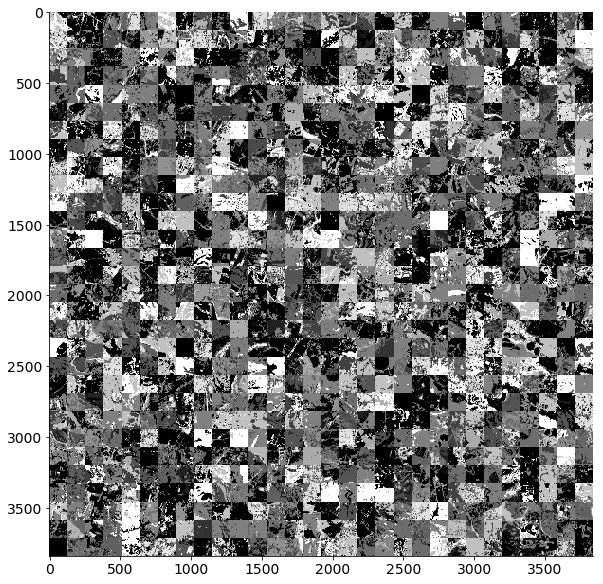

In [55]:
# Display
plt_style()
plt.imshow(montage)

Text(0.5,1,'Positive cases')

<Figure size 432x288 with 0 Axes>

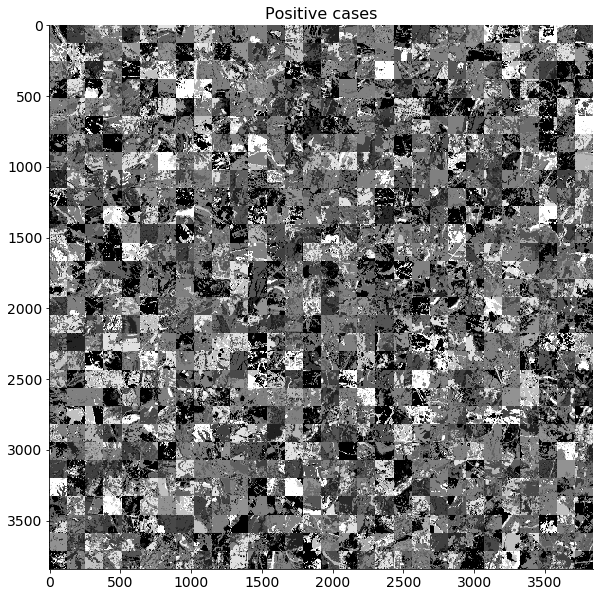

In [59]:
# Fire positive
# Build montage
montage = CPutils.montage_data(sample=900, 
                               dataset=os.path.join(NEW_CONSOLIDATED_PATH, 'fire'), 
                               save=True, 
                               text='Positive cases', 
                               textCoord=(0,0), 
                               textColor=None, 
                               outFileName=os.path.join(NEW_CONSOLIDATED_PATH, 'fire_collage.png'),
                               imgShape=(128,128),
                               montageShape=(30,30),
                               fontScale=2,
                               seed=42,
                               show=False)

# Display
plt_style()
plt.imshow(montage)
plt.title('Positive cases')

Text(0.5,1,'Negative cases')

<Figure size 432x288 with 0 Axes>

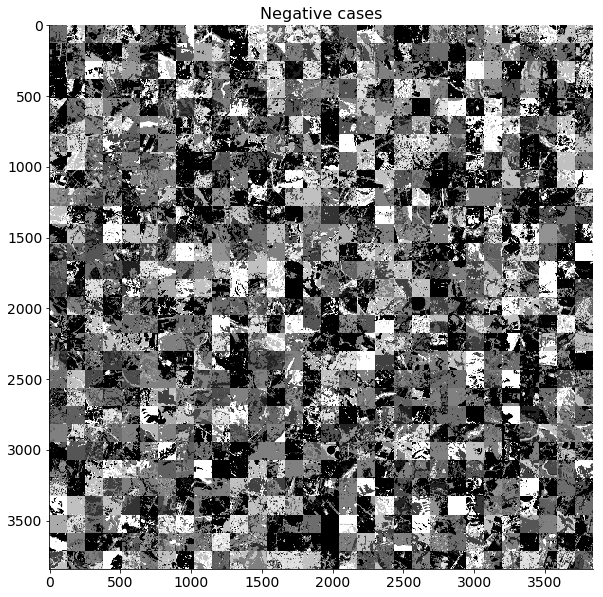

In [58]:
# No Fire 
# Build montage
montage = CPutils.montage_data(sample=900, 
                               dataset=os.path.join(NEW_CONSOLIDATED_PATH, 'no_fire'), 
                               save=True, 
                               text='Positive cases', 
                               textCoord=(0,0), 
                               textColor=None, 
                               outFileName=os.path.join(NEW_CONSOLIDATED_PATH, 'no_fire_collage.png'),
                               imgShape=(128,128),
                               montageShape=(30,30),
                               fontScale=2,
                               seed=42,
                               show=False)

# Display
plt_style()
plt.imshow(montage)
plt.title('Negative cases')

# Clean no data files
- Some images are empty. Thus, we need to delete them from the images folder and the consolidated excel file.
- Already implemented at the initial step.

In [ ]:
print("Mean:", consolidatedTop.lcV0.mean(),
      "\nMax:", consolidatedTop.lcV0.max(),
      "\nMin:", consolidatedTop.lcV0.min(),
      "\nSTD:", consolidatedTop.lcV0.std())

In [ ]:
consolidatedTop[consolidatedTop.lcV0 >= .1].shape

In [ ]:
consolidatedTop[consolidatedTop.lcV0 >= .5].shape

In [ ]:
consolidatedTop[consolidatedTop.lcV0 >= .25].shape

In [ ]:
# Common mediterranean shrubs located mainly in v,rm,vi, and vii regionss
_ = cv2.imread('data/Consolidated/dataset/0_38.tif', -1)
plt.imshow(_, cmap='gray')
_

# Generate training and testing sets
- Using the consolidated excel, generate the traiing and testing sets.

In [ ]:
# Custom importation for dataset preprocessing
import shutil
def pre_process_dataset():
    # loop over the data splits
    for split in (TRAIN, TEST, VAL):
        # grab all image paths in the current split
        print("[INFO] processing '{} split'...".format(split))
        p = os.path.sep.join([ORIG_INPUT_DATASET, split])
        imagePaths = list(paths.list_images(p))

        # loop over the image paths
        for imagePath in imagePaths:
            # extract class label from the filename
            filename = imagePath.split(os.path.sep)[-1]
            label = CLASSES[int(filename.split("_")[0])]

            # construct the path to the output directory
            dirPath = os.path.sep.join([BASE_PATH, split, label])

            # if the output directory does not exist, create it
            if not os.path.exists(dirPath):
                os.makedirs(dirPath)

            # construct the path to the output image file and copy it
            p = os.path.sep.join([dirPath, filename])
            shutil.copy2(imagePath, p)